In [1]:
library(dplyr,warn.conflicts=F)
library(psych,warn.conflicts=F)
library(ggplot2,warn.conflicts=F)
library(stringr,warn.conflicts=F)

In [2]:
# load the stats
data.regular <- readRDS('datafiles_rds/RegularSeasonDetailedResults.rds')
data.tourney <- readRDS('datafiles_rds/NCAATourneyDetailedResults.rds')

In [3]:
# keep 2014
data.regular %>% filter(Season==2014) -> data.reg2014
data.tourney %>% filter(Season==2014) -> data.tou2014

In [4]:
# store 68 tourney teams 
data.tou2014 %>% 
    select(TeamID=WTeamID) %>% 
    bind_rows(data.tou2014 %>% 
              select(TeamID=LTeamID)) %>% 
    distinct(TeamID) -> df.teams2014

In [5]:
# compute average delta scores (win>0, loss<0) to rate teams
data.reg2014 %>% 
    select(WTeamID,LTeamID,WScore,LScore) %>% 
    mutate(WDelta=WScore-LScore,LDelta=LScore-WScore) -> tmp01
tmp01 %>% 
    select(TeamID=WTeamID,Delta=WDelta) %>% 
    bind_rows(tmp01 %>% 
              select(TeamID=LTeamID,Delta=LDelta)) %>% 
    group_by(TeamID) %>% 
    summarise(DeltaScore=mean(Delta)) -> df.delta 

In [6]:
describe(df.delta)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
TeamID,1,351,1283.8091168,104.038979,1283.0000000,1283.9893238,133.434000,1101.00000,1464.00000,363.00000,-0.008433991,-1.1955760,5.5531899
DeltaScore,2,351,-0.2276406,6.325656,-0.3225806,-0.2803153,6.489962,-16.71429,21.14706,37.86134,0.074497540,-0.1070243,0.3376386


In [7]:
# compute average delta score for the winners only
tmp01 %>% 
    select(TeamID=WTeamID,Delta=WDelta) %>% 
    bind_rows(tmp01 %>% 
              select(TeamID=LTeamID,Delta=LDelta)) %>% 
    filter(Delta>0) %>% 
    group_by(TeamID) %>% 
    summarise(DeltaScore=mean(Delta)) -> df.Wdelta 

In [8]:
describe(df.Wdelta)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
TeamID,1,351,1283.8091,104.038979,1283.00000,1283.98932,133.43400,1101.0,1464.00000,363.00000,-0.008433991,-1.195576,5.5531899
DeltaScore,2,351,10.8169,3.285626,10.58333,10.70077,2.89107,2.6,25.86207,23.26207,0.559832334,1.344661,0.1753737


In [9]:
# mean - sigma = threshold
threshold = 10.8169 - 3.285626
threshold

[1] 7.531274

In [10]:
# compute slope of sigmoid
slope = 3 / threshold
slope

[1] 0.398339

In [11]:
# 95% proba is now for delta = threshold instead of 3
logistic(3)
logistic(threshold,a=slope)

[1] 0.9525741

[1] 0.9525741

In [12]:
# matchups dataframe
df.delta %>% 
    semi_join(df.teams2014,by='TeamID') %>% 
    mutate(Season=2014) -> tmp01
tmp01 %>% 
    inner_join(tmp01,by='Season') %>% 
    filter(TeamID.x < TeamID.y) -> df.matchup
df.matchup %>% sample_n(5)

TeamID.x,DeltaScore.x,Season,TeamID.y,DeltaScore.y
1264,7.375000,2014,1361,10.516129
1174,4.382353,2014,1444,4.064516
1276,9.030303,2014,1295,7.285714
1243,4.000000,2014,1386,4.333333
1438,10.647059,2014,1444,4.064516


In [13]:
# machups predictions
df.matchup %>% 
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(DeltaScore.x-DeltaScore.y,a=slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    select(ID,Pred,Prob) -> df.submit
df.submit %>% sample_n(5)

ID,Pred,Prob
2014_1397_1458,1,0.51546088
2014_1217_1433,1,0.69099131
2014_1217_1372,0,0.43381620
2014_1140_1243,1,0.74311786
2014_1174_1326,0,0.09539747


In [14]:
# compute the Truth 
data.tou2014 %>% 
    select(Season,WTeamID,LTeamID) %>% 
    mutate(TeamID.1=ifelse(WTeamID<LTeamID,WTeamID,LTeamID),
           TeamID.2=ifelse(WTeamID>LTeamID,WTeamID,LTeamID)) %>%
    mutate(ID=str_c(Season,'_',TeamID.1,'_',TeamID.2)) %>% 
    mutate(Target=ifelse(WTeamID==TeamID.1,1,0)) %>% 
    select(ID,Target) -> df.truth
df.truth %>% sample_n(5)

ID,Target
2014_1235_1314,1
2014_1142_1411,1
2014_1301_1387,0
2014_1174_1277,0
2014_1217_1277,0


In [15]:
# merge prediction and truth
df.truth %>% inner_join(df.submit,by='ID') -> results

In [16]:
# confusion matrix
cm <- table(results$Target,results$Pred)
cm
perf <- (cm[1,1]+cm[2,2]) / nrow(results)
perf

   
     0  1
  0 20  9
  1 15 23

[1] 0.641791

In [17]:
# logloss (kaggle metric)
results %>% 
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>% 
    summarise(ModelLogLoss = -mean(LogLoss))

# Baseline 
results %>% 
    mutate(LogLoss=Target*log(0.5) + (1-Target)*log(0.5)) %>% 
    summarise(BaseLogLoss = -mean(LogLoss))

ModelLogLoss
0.7277268


BaseLogLoss
0.6931472


$$f(x) = \frac{L}{1+e^{-k(x-x_0)}} + C$$

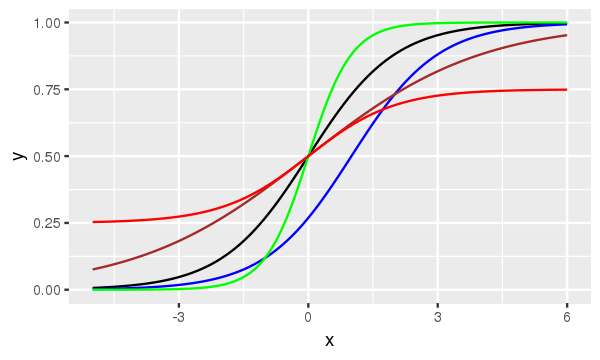

In [18]:
options(repr.plot.width=5, repr.plot.height=3)
ggplot(data.frame(x=c(-5, 6)), aes(x)) + 
    stat_function(fun=function(x) logistic(x)) + 
    stat_function(fun=function(x) logistic(x,d=1), color='blue') +
    stat_function(fun=function(x) logistic(x,a=2), color='green') +
    stat_function(fun=function(x) logistic(x,a=0.5), color='brown') +
    stat_function(fun=function(x) logistic(x,c=0.25,z=0.75), color='red')

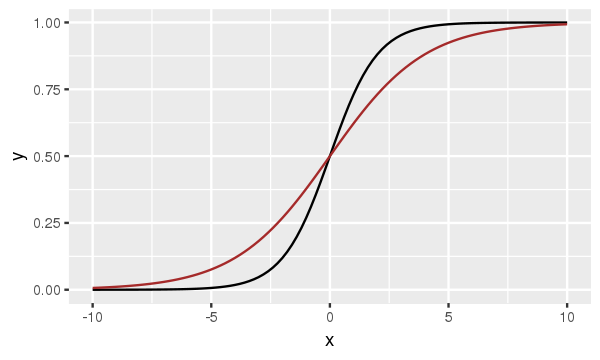

In [19]:
ggplot(data.frame(x=c(-10, 10)), aes(x)) + 
    stat_function(fun=function(x) logistic(x)) + 
    stat_function(fun=function(x) logistic(x,a=0.5), color='brown')